In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def cartoonify_image(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply median blur for noise reduction
    gray_blur = cv2.medianBlur(gray, 7)
    # Apply Laplacian filter for edge detection
    edges = cv2.Laplacian(gray_blur, cv2.CV_8U, ksize=5)
    edges_thresh = cv2.threshold(edges, 100, 255, cv2.THRESH_BINARY)[1]
    img_small = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2))
    for _ in range(30):
        img_small = cv2.bilateralFilter(img_small, 9, 10, 200)
    color = cv2.resize(img_small, (img.shape[1], img.shape[0]))
    # Combine edges with the color image
    edges_inv = cv2.bitwise_not(edges_thresh)
    cartoon = cv2.bitwise_and(color, color, mask=edges_inv)
    
    # Show results
    plt.figure(figsize=(20, 10)),plt.subplot(2, 3, 1),plt.imshow(img),plt.title("Original Image"),plt.axis("off")

    plt.subplot(2, 3, 2),plt.imshow(gray, cmap="gray"),plt.title("Grayscale Image"),plt.axis("off")

    plt.subplot(2, 3, 3),plt.imshow(gray_blur, cmap="gray"),plt.title("After Median Blur"),plt.axis("off")

    plt.subplot(2, 3, 4),plt.imshow(edges, cmap="gray"),plt.title("Edge Detection (Laplacian)"),plt.axis("off")

    plt.subplot(2, 3, 5),plt.imshow(edges_inv, cmap="gray"),plt.title("Edge Detection (Thresholded)"),plt.axis("off")

    plt.subplot(2, 3, 6),plt.imshow(cartoon),plt.title("Cartoon Effect"),plt.axis("off")

    plt.show()

used RGB format as it is standard for displaying 
we first convert image to greyscale since laplacian use grey scale images  This helps in edge detection since colors are removed, and intensity variations are retained
applied non linear median filter , Median blur is used to reduce noise while preserving edges in the image
The Laplacian operator is a second-order derivative filter used to detect edges
It enhances regions with high intensity variations, making the edges more clear
threshold---> Converts edge detection results into a binary image
Pixels with intensity above 100 are set to 255 (white), and others are set to 0 (black)
A bilateral filter is applied 30 times to smooth the image while preserving edges.
bilateral filtering does not blur edges, maintaining the structure of objects in the image
we use resize Since bilateral filtering is computationally expensive, it is applied to a downsampled image for efficiency
then Invert the edge-detected image so that edges become black (0) and the rest of the image becomes white (255)
Applies the edge mask onto the smoothed color image.
This ensures that only the detected edges are retained in black while the rest of the image has the smoothed color

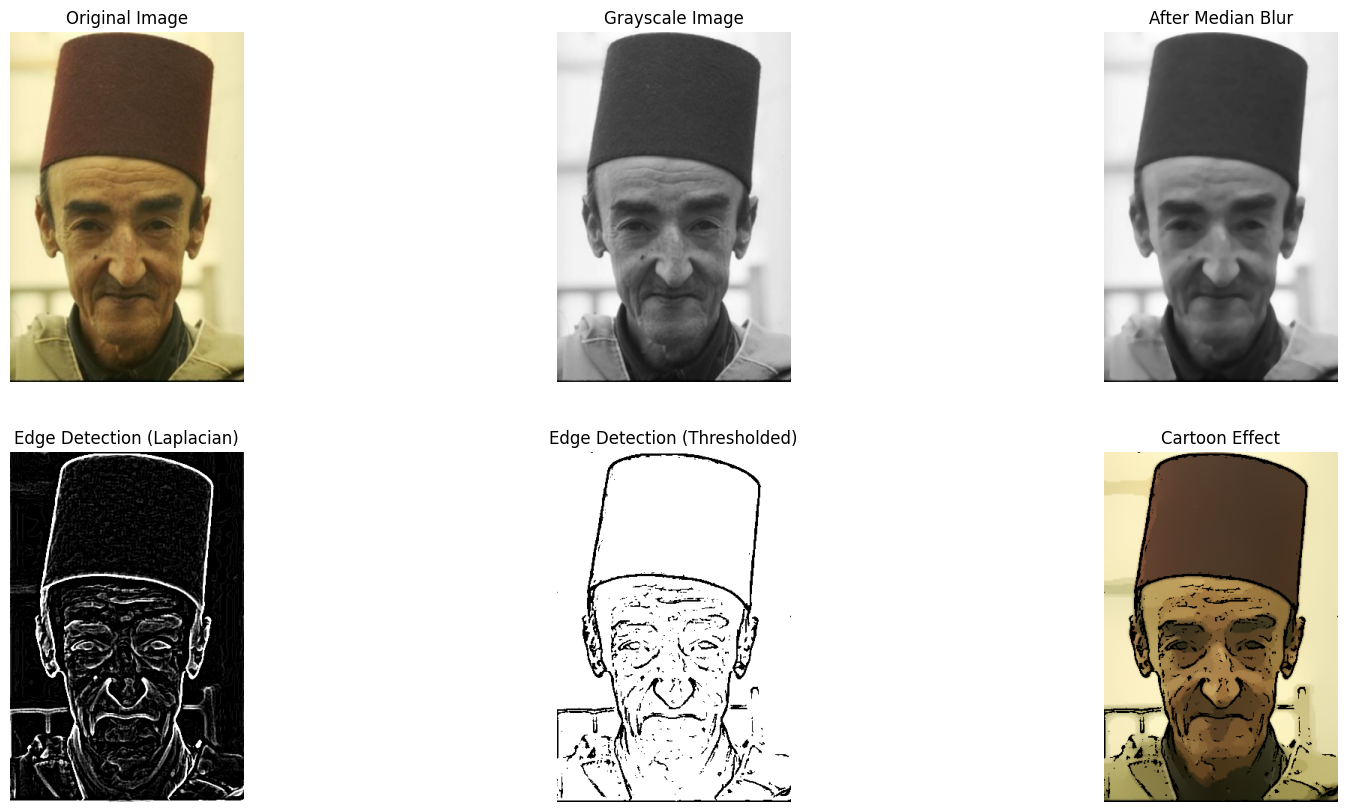

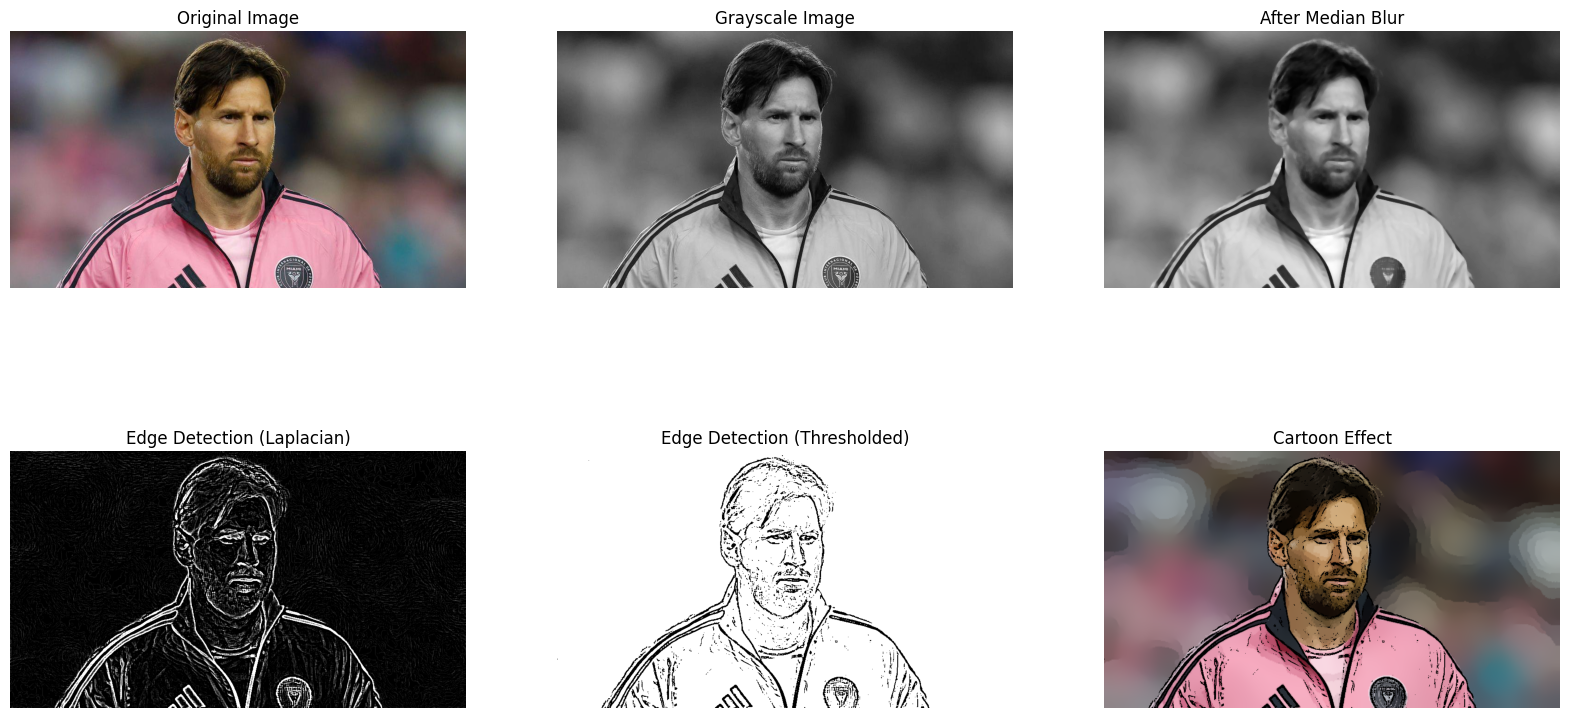

In [5]:
cartoonify_image("test images/man.jpg")
cartoonify_image("test images/Goat.jpg")

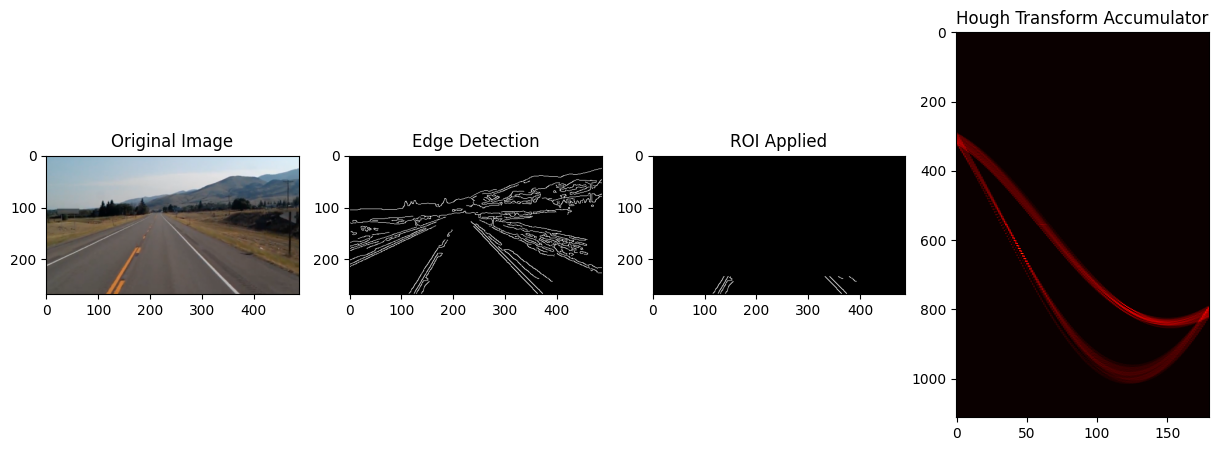

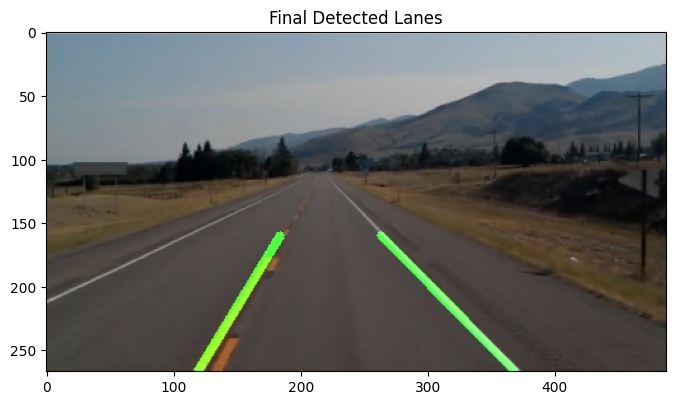

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    """Convert to grayscale, equalize histogram, apply Gaussian blur, and detect edges."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)  # Enhances contrast
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)  # Edge detection

    return edges

def region_of_interest(image):
    """Apply a mask to focus on the road lanes."""
    height, width = image.shape
    mask = np.zeros_like(image)

    polygon = np.array([
        [(0, height), (width // 2 - 200, height // 2 + 100), 
         (width // 2 + 200, height // 2 + 100), (width, height)]
    ], dtype=np.int32)

    cv2.fillPoly(mask, polygon, 255)
    return cv2.bitwise_and(image, mask)

def manual_hough_transform(edges, theta_res=1, rho_res=1, threshold=20):
    """Manual Hough Transform: Accumulator voting for lines."""
    height, width = edges.shape
    diag_len = int(np.sqrt(height**2 + width**2))  # Max rho value
    rhos = np.arange(-diag_len, diag_len, rho_res)
    thetas = np.deg2rad(np.arange(-90, 90, theta_res))  # -90 to 90 degrees

    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.int32)
    edge_points = np.argwhere(edges)  # Get edge coordinates (y, x)

    for y, x in edge_points:
        for theta_idx, theta in enumerate(thetas):
            rho = int(x * np.cos(theta) + y * np.sin(theta))
            rho_idx = np.where(rhos == rho)[0]
            if rho_idx.size > 0:
                accumulator[rho_idx[0], theta_idx] += 1

    # Extract lines exceeding threshold
    line_indices = np.argwhere(accumulator > threshold)
    lines = []
    for rho_idx, theta_idx in line_indices:
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
        x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
        lines.append([(x1, y1, x2, y2)])

    return lines, accumulator

def filter_lines(lines, width):
    """Filter out unwanted lines based on slope."""
    left_lines, right_lines = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1 + 1e-6)

        if 0.4 < abs(slope) < 2:  # Remove nearly horizontal/vertical lines
            if slope < 0 and x1 < width * 0.6:  # Left lane condition
                left_lines.append(line)
            elif slope > 0 and x1 > width * 0.4:  # Right lane condition
                right_lines.append(line)

    return left_lines, right_lines

def average_lines(image, lines):
    """Smooth lane lines using weighted averaging."""
    if not lines:
        return None

    x_coords, y_coords = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        x_coords += [x1, x2]
        y_coords += [y1, y2]

    poly = np.polyfit(x_coords, y_coords, 1)  # Linear fit
    y1, y2 = image.shape[0], int(image.shape[0] * 0.6)
    x1, x2 = int((y1 - poly[1]) / poly[0]), int((y2 - poly[1]) / poly[0])
    return [[x1, y1, x2, y2]]

def draw_lines(image, lines):
    """Draw detected lane lines on the image."""
    line_image = np.zeros_like(image)
    if lines:
        for line in lines:
            if line is not None:
                x1, y1, x2, y2 = line[0]
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)
    return cv2.addWeighted(image, 0.8, line_image, 1, 0)

# Load image and run processing pipeline
image = cv2.imread("test4.png")
edges = preprocess_image(image)
roi_edges = region_of_interest(edges)
lines, accumulator = manual_hough_transform(roi_edges)

# Filter and average detected lines
left_lines, right_lines = filter_lines(lines, image.shape[1])
left_avg = average_lines(image, left_lines)
right_avg = average_lines(image, right_lines)

# Draw detected lanes
detected_image = draw_lines(image, [left_avg, right_avg])

# Show results
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

# Edge Detection
plt.subplot(1, 4, 2)
plt.imshow(edges, cmap='gray')
plt.title('Edge Detection')

# ROI Applied
plt.subplot(1, 4, 3)
plt.imshow(roi_edges, cmap='gray')
plt.title('ROI Applied')

# Accumulator array
plt.subplot(1, 4, 4)
plt.imshow(accumulator, cmap='hot', aspect='auto')
plt.title('Hough Transform Accumulator')

plt.show()

# Show Final Lane Detection
plt.figure(figsize=(8, 5))
plt.imshow(cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB))
plt.title('Final Detected Lanes')
plt.show()
